In [1]:
import sys
sys.path.append("../../code")
sys.path.append("../code")


from matrix_factorisation import nmf_features, transform, transform_2, preprocess, get_static_features, preprocess_all_appliances
from matrix_factorisation import transform_all_appliances
import  os

import numpy as np
import pandas as pd
import pickle
import sys
sys.path.append("../../code")
from features import feature_map

def _save_results(appliance, lat, feature_comb, test_home, pred_df):
    pred_df.to_csv(os.path.expanduser("~/collab_subset/%s_%d_%s_%d.csv" %(appliance, lat, '_'.join(feature_comb), test_home)))

out_overall = pickle.load(open('../../data/input/all_regions.pkl', 'r'))

region = "Austin"

df = out_overall[region]

df_copy = df.copy()
#drop_rows_having_no_data
o = {}
for h in df.index:
    o[h]=len(df.ix[h][feature_map['Monthly+Static']].dropna())
num_features_ser = pd.Series(o)
drop_rows = num_features_ser[num_features_ser==0].index

df = df.drop(drop_rows)
dfc = df.copy()
dfc = dfc[(dfc.full_agg_available == 1) & (dfc.md_available == 1)]


df = df.rename(columns={'house_num_rooms':'num_rooms',
                        'num_occupants':'total_occupants',
                        'difference_ratio_min_max':'ratio_difference_min_max'})


df = df[(df.full_agg_available == 1) & (df.md_available == 1)]

from all_functions import *
from features_larger import *

import itertools
feature_combinations = [['None']]
for l in range(1,4):
    for a in itertools.combinations(['occ','area','rooms'], l):
        feature_combinations.append(list(a))





out = {}


    

In [2]:

def _save_results_all_appliances(lat, feature_comb, test_home, pred_df):
    pred_df.to_csv(os.path.expanduser("~/collab_subset_all_appliances/%d_%s_%d.csv" %(lat, '_'.join(feature_comb), test_home)))



In [3]:
X_matrix, X_normalised, col_max, col_min, appliance_cols, aggregate_cols, all_appliances_cols, all_appliance_cols_flat = preprocess_all_appliances(df, dfc)
static_features= get_static_features(dfc, X_normalised)
from copy import deepcopy
all_cols = deepcopy(appliance_cols)
all_cols.extend(aggregate_cols)
all_appliances = ['mw','oven','hvac','fridge','dw','wm']


In [5]:
for home in dfc.index[:]:
    print home
    for feature_comb in np.array(feature_combinations)[:4]:
        out[tuple(feature_comb)]={}
        if 'None' in feature_comb:
            idx_user=None
            data_user=None
        else:
            idx_user = {}
            data_user = {}
            dictionary_static = {}
            for feature in feature_comb:
                dictionary_static[feature]=static_features[feature]
            static_features_df = pd.DataFrame(dictionary_static, index=range(len(X_normalised.index)))


            for fe in static_features_df.columns:
                idx_user[fe]=np.where(static_features_df[fe].notnull())[0]
                data_user[fe]=static_features_df[fe].dropna().values

        for lat in range(1,4):
            try:
                

                if lat<len(feature_comb):
                    continue
                out[tuple(feature_comb)][lat]={}

                X_home = X_normalised.copy()
                for appliance in all_appliances:
                    
                    if appliance=="hvac":
                        #start, end=5, 11
                        start, end=1,13
                    else:
                        start, end = 1, 13
                    for month in range(start, end):
                        X_home.loc[home, '%s_%d' %(appliance, month)] = np.NAN


                mask = X_home.notnull().values
                # Ensure repeatably random problem data.
                A = X_home.copy()
                X, Y, res = nmf_features(A, lat, 0.01, False, idx_user, data_user, 10)

                pred_df = pd.DataFrame(Y*X)
                pred_df.columns = X_normalised.columns
                pred_df.index = X_normalised.index
                pred_df = transform_all_appliances(pred_df.ix[home],all_appliances, col_max, col_min)[all_appliance_cols_flat]
                _save_results_all_appliances(lat, feature_comb, home, pred_df)
                #out[lat][home] = transform_2(pred_df.ix[home],all_appliances, col_max, col_min)[all_appliance_cols_flat]
                #out[tuple(feature_comb)][lat] = transform_2(pred_df.ix[test_home], appliance, col_max, col_min)[appliance_cols]
                #pred_df = transform_2(pred_df.ix[test_home], appliance, col_max, col_min)[appliance_cols]
                #_save_results(appliance, lat, feature_comb, test_home, pred_df)
            except Exception, e:
                print "Exception occured", e

26
59
94
101
222
252
364
545
624
661
871
946
1169
1283
1310
1334
1415
1463
1500
1642
1697
1700
1790
1800
1953
2129
2156
2233
2242
2365
2378
2470
2557
2814
2859
2925
2953
2986
3009
3036
3367
3456
3482
3577
3649
3723
3778
3829
3893
3967
4031
4213
4297
4298
4342
4505
4767
4874
4946
4957
4998
5026
5218
5357
5371
5439
5673
5677
5785
5814
5817
6121
6139
6266
6498
6692
6836
6910
7016
7390
7429
7510
7641
7731
7741
7769
7793
7800
7866
8236
8243
8317
8626
9052
9134
9484
9609
9647
9729
9912
9922
9932
9933
9971
9982


In [6]:
def compute_prediction(feature, k):
    files = glob.glob(path+'%d_%s_*.csv' %(k, feature))
    out = {}
    for e in files:
        out[int(e.split('_')[-1][:-4])] = pd.read_csv(e,index_col=0, header=None).squeeze()
    return pd.DataFrame(out).T

In [15]:
import glob
from sklearn.metrics import mean_squared_error
path = os.path.expanduser("/Users/nipunbatra/collab_subset_all/")
best_combination={}
for appliance in all_appliances:
    best_appliance=1000
    for appliance_feature in ['None','area','occ','rooms']:
        for latent_factors in range(1, 4):
            try:
                region = "Austin"
                df = out_overall[region]
                if appliance=="hvac":
                    start, end=5, 11
                    #start, end=1,13
                else:
                    start, end = 1, 13
                pred_overall = compute_prediction(appliance_feature, latent_factors)
                appliance_cols = ['%s_%d' %(appliance, month) for month in range(start, end)]
                gt = X_matrix[appliance_cols].dropna()
    

                pr = pred_overall[appliance_cols].ix[gt.index]

                rms = np.sqrt(mean_squared_error(gt, pr))
                #rms = np.sqrt(mean_squared_error(gt_df, pred_df))

                if rms<best_appliance:

                    best_appliance=rms
                    best_combination[appliance]=(appliance_feature, latent_factors, rms)
            except Exception, e:
                print e
    #result['MF-105 homes, feature'][appliance]=best_appliance
            
print best_combination

{'hvac': ('occ', 3, 224.19030701549764), 'wm': ('rooms', 3, 5.7666498585776704), 'fridge': ('None', 3, 39.543292407211148), 'mw': ('area', 1, 6.0949853319101193), 'oven': ('area', 1, 10.527356476187146), 'dw': ('occ', 1, 8.8511731748686895)}


In [12]:

from sklearn.metrics import mean_squared_error
for appliance in all_appliances:
    for feature in
    if appliance=="hvac":
        start, end=5, 11
        #start, end=1,13
    else:
        start, end = 1, 13
    appliance_cols = ['%s_%d' %(appliance, month) for month in range(start, end)]
    gt = X_matrix[appliance_cols].dropna()
    

    pr = pred_overall[appliance_cols].ix[gt.index]

    error = np.sqrt(mean_squared_error(gt, pr))
    print appliance, error


SyntaxError: invalid syntax (<ipython-input-12-08774247bec5>, line 4)

In [32]:
error

5.8001408076085186

In [6]:
all_appliances = ['mw','oven','hvac','fridge','dw','wm']
all_appliance_cols = []
for appliance in all_appliances:
    if appliance=="hvac":
        #start, end=5, 11
        start, end=1,13
    else:
        start, end = 1, 13

    appliance_cols = ['%s_%d' %(appliance, month) for month in range(start, end)]
    all_appliance_cols.append(appliance_cols)
    
aggregate_cols = ['aggregate_%d' %month for month in range(1, 13)]

all_appliance_cols_flat = []
for y in all_appliance_cols:
    for x in y:
        all_appliance_cols_flat.append(x)
all_cols = deepcopy(all_appliance_cols_flat)
all_cols.extend(aggregate_cols)
X_matrix = dfc[all_cols]
    

In [7]:
X_matrix.columns

Index([u'mw_1', u'mw_2', u'mw_3', u'mw_4', u'mw_5', u'mw_6', u'mw_7', u'mw_8',
       u'mw_9', u'mw_10', u'mw_11', u'mw_12', u'oven_1', u'oven_2', u'oven_3',
       u'oven_4', u'oven_5', u'oven_6', u'oven_7', u'oven_8', u'oven_9',
       u'oven_10', u'oven_11', u'oven_12', u'hvac_1', u'hvac_2', u'hvac_3',
       u'hvac_4', u'hvac_5', u'hvac_6', u'hvac_7', u'hvac_8', u'hvac_9',
       u'hvac_10', u'hvac_11', u'hvac_12', u'fridge_1', u'fridge_2',
       u'fridge_3', u'fridge_4', u'fridge_5', u'fridge_6', u'fridge_7',
       u'fridge_8', u'fridge_9', u'fridge_10', u'fridge_11', u'fridge_12',
       u'dw_1', u'dw_2', u'dw_3', u'dw_4', u'dw_5', u'dw_6', u'dw_7', u'dw_8',
       u'dw_9', u'dw_10', u'dw_11', u'dw_12', u'wm_1', u'wm_2', u'wm_3',
       u'wm_4', u'wm_5', u'wm_6', u'wm_7', u'wm_8', u'wm_9', u'wm_10',
       u'wm_11', u'wm_12', u'aggregate_1', u'aggregate_2', u'aggregate_3',
       u'aggregate_4', u'aggregate_5', u'aggregate_6', u'aggregate_7',
       u'aggregate_8', u'aggregate_

In [8]:
columns_max = {}
columns_min = {}
col_max = X_matrix.max()
columns_max[appliance]=col_max
col_min = X_matrix.min()
columns_min[appliance]=col_min
X_normalised = X_matrix.copy()
#for col in X_matrix.columns:
#    X_normalised[col] = (X_matrix[col]-col_min[col])/(col_max[col]-col_min[col])
for col in X_matrix.columns:
    X_normalised[col] = (X_matrix[col]-col_min.min())/(col_max.max()-col_min.min())



In [9]:
pd.DataFrame(X_normalised).head()

,mw_1,mw_2,mw_3,mw_4,mw_5,mw_6,mw_7,mw_8,mw_9,mw_10,...,aggregate_3,aggregate_4,aggregate_5,aggregate_6,aggregate_7,aggregate_8,aggregate_9,aggregate_10,aggregate_11,aggregate_12
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.024749,0.025112,0.027550,0.024593,NaN,NaN,NaN,NaN,NaN,NaN
26,0.000497,0.000379,0.000400,0.000336,0.000336,0.000338,0.000371,0.000328,0.00032,0.000336,...,0.052131,0.068539,0.084369,0.121612,0.150097,0.166157,0.120156,0.105391,0.063597,0.057199
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.135265,0.090938,0.097497,0.091864,0.124270,0.159477,0.090748,0.081748,0.093503,0.154903
68,0.001742,0.002008,0.002117,0.002115,0.002173,0.002277,0.001163,0.000556,NaN,NaN,...,0.020003,0.024372,0.022751,0.022225,0.020207,0.012236,NaN,NaN,NaN,NaN
77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.104112,0.077983,0.085140,0.110119,0.131291,0.134408,0.106513,0.082660,0.068267,0.093485


In [7]:
df = pd.DataFrame(X_normalised)

In [8]:
def transform_2(pred_df,all_appliances,  col_max, col_min):
    pred_df_copy = pred_df.copy()
    
    for appliance in all_appliances:
    
        if appliance=="hvac":
            start, stop=5, 11
        else:
            start, stop=1, 13

        for month in range(start, stop):
            pred_df_copy['%s_%d' %(appliance,month)] = (col_max.max()-col_min.min())*pred_df['%s_%d'%(appliance,month)] +col_min.min()
    return pred_df_copy

def transform(pred_df,appliance,  col_max, col_min):
    pred_df_copy = pred_df.copy()
    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop=1, 13
    
    for month in range(start, stop):
        pred_df_copy['%s_%d' %(appliance,month)] = (col_max['%s_%d' %(appliance, month)]-col_min['%s_%d' %(appliance,month)])*pred_df['%s_%d'%(appliance,month)] +col_min['%s_%d' %(appliance,month)]
    return pred_df_copy



In [9]:
def nmf_features(A, k, f, MAX_ITERS=30):
    np.random.seed(0)

    # Generate random data matrix A.
    m = len(A)
    n = len(A.columns)
    
    
    # Initialize Y randomly.
    Y_init = np.random.rand(m, k)

    # Ensure same initial random Y, rather than generate new one
    # when executing this cell.
    Y = Y_init
    #Y[0] = f

    # Perform alternating minimization.
    
    residual = np.zeros(MAX_ITERS)
    for iter_num in range(1, 1+MAX_ITERS):
        # At the beginning of an iteration, X and Y are NumPy
        # array types, NOT CVXPY variables.

        # For odd iterations, treat Y constant, optimize over X.
        if iter_num % 2 == 1:
            X = cvx.Variable(k, n)
            constraint = [X >= 0]
        # For even iterations, treat X constant, optimize over Y.
        else:
            Y = cvx.Variable(m, k)
            
            constraint = [Y >= 0, Y[:,:np.shape(f)[1]]==f]
            
            #Y.value[0]=f
        Temp = Y*X

        # Solve the problem.
        obj = cvx.Minimize(cvx.norm(A.values[mask] - (Y*X)[mask], 'fro'))
        prob = cvx.Problem(obj, constraint)
        prob.solve(solver=cvx.SCS)

        if prob.status != cvx.OPTIMAL:
            pass
            #return X.value, Y.value, residual
            #raise Exception("Solver did not converge!")

        #print 'Iteration {}, residual norm {}'.format(iter_num, prob.value)
        residual[iter_num-1] = prob.value

        # Convert variable to NumPy array constant for next iteration.
        if iter_num % 2 == 1:
            X = X.value
        else:
            Y = Y.value
    return X, Y, residual

In [10]:
def nmf(A, k, MAX_ITERS=30):
    np.random.seed(0)

    # Generate random data matrix A.
    m = len(A)
    n = len(A.columns)
    
    
    # Initialize Y randomly.
    Y_init = np.random.rand(m, k)

    # Ensure same initial random Y, rather than generate new one
    # when executing this cell.
    Y = Y_init 

    # Perform alternating minimization.
    
    residual = np.zeros(MAX_ITERS)
    for iter_num in range(1, 1+MAX_ITERS):
        # At the beginning of an iteration, X and Y are NumPy
        # array types, NOT CVXPY variables.

        # For odd iterations, treat Y constant, optimize over X.
        if iter_num % 2 == 1:
            X = cvx.Variable(k, n)
            constraint = [X >= 0]
        # For even iterations, treat X constant, optimize over Y.
        else:
            Y = cvx.Variable(m, k)
            constraint = [Y >= 0]
        Temp = Y*X

        # Solve the problem.
        obj = cvx.Minimize(cvx.norm(A.values[mask] - (Y*X)[mask], 'fro'))
        prob = cvx.Problem(obj, constraint)
        prob.solve(solver=cvx.SCS)

        if prob.status != cvx.OPTIMAL:
            pass
            #return X.value, Y.value, residual
            #raise Exception("Solver did not converge!")

        #print 'Iteration {}, residual norm {}'.format(iter_num, prob.value)
        residual[iter_num-1] = prob.value

        # Convert variable to NumPy array constant for next iteration.
        if iter_num % 2 == 1:
            X = X.value
        else:
            Y = Y.value
    return X, Y, residual

In [15]:
area = dfc.ix[X_normalised.index].area.div(dfc.ix[X_normalised.index].area.max()).reshape((len(X_normalised),1))
occ = dfc.ix[X_normalised.index].num_occupants.div(dfc.ix[X_normalised.index].num_occupants.max()).reshape((len(X_normalised),1))
rooms = dfc.ix[X_normalised.index].house_num_rooms.div(dfc.ix[X_normalised.index].house_num_rooms.max()).reshape((len(X_normalised),1))

out = {}
for lat in range(1,10):
    out[lat]={}
    print lat
    for home in X_normalised.index[:]:
        
        X_home = X_normalised.copy()
        for appliance in all_appliances:
            for month in range(start, end):
                X_home.loc[home, '%s_%d' %(appliance, month)] = np.NAN
        mask = X_home.notnull().values
        # Ensure repeatably random problem data.
        A = X_home.copy()
        X, Y, res = nmf_features(A, lat,area, 10)
        
        pred_df = pd.DataFrame(Y*X)
        pred_df.columns = X_normalised.columns
        pred_df.index = X_normalised.index
        #out[lat][home] = pred_df.ix[home][appliance_cols]
        out[lat][home] = transform_2(pred_df.ix[home],all_appliances, col_max, col_min)[all_appliance_cols_flat]


1
2
3
4
5
6
7
8
9


In [16]:
error_lat = {}
for appliance in all_appliances:
    error_lat[appliance]={}
    if appliance=="hvac":
        start, end=5, 11
        #start, end=1,13
    else:
        start, end = 1, 13
    appliance_cols = ['%s_%d' %(appliance, month) for month in range(start, end)]
    gt = X_matrix[appliance_cols]
    
    for lat in range(1,10):

        pr = pd.DataFrame(out[lat]).T

        error = (pr-gt).abs()
        error_lat[appliance][lat] = error.div(gt).mul(100).median().mean()
pd.DataFrame(error_lat)

,dw,fridge,hvac,mw,oven,wm
1,54.426397,28.125450,35.048725,45.254498,53.689221,49.480212
2,53.852222,29.793324,29.166555,44.202941,53.338395,44.680635
3,53.574346,31.193506,19.583177,46.041678,55.439816,41.384355
4,54.476665,32.468068,27.004989,47.093809,60.485085,44.590697
5,54.745183,36.627401,25.480343,50.439318,58.493893,50.121264
6,54.398679,32.006868,27.093455,48.194516,51.347511,48.942305
7,54.719791,33.946873,28.077745,47.447438,50.193503,47.606904
8,57.253011,38.395330,32.041669,48.687325,64.692231,58.231676
9,55.148274,37.753862,32.040605,48.546011,54.631151,52.616952


In [24]:
error_lat = {}
for appliance in all_appliances:
    error_lat[appliance]={}
    if appliance=="hvac":
        start, end=5, 11
        #start, end=1,13
    else:
        start, end = 1, 13
    appliance_cols = ['%s_%d' %(appliance, month) for month in range(start, end)]
    gt = X_matrix[appliance_cols]
    
    for lat in range(1,10):

        pr = pd.DataFrame(out[lat]).T

        error = (pr-gt).abs()
        error_lat[appliance][lat] = error.div(gt).mul(100).median().mean()
pd.DataFrame(error_lat)

,dw,fridge,hvac,mw,oven,wm
1,54.465959,28.472909,29.038784,45.332588,52.352397,45.292877
2,54.871356,31.905234,20.143806,45.635348,53.216279,40.154435
3,55.831237,32.427419,26.035662,46.863918,52.815503,46.888093
4,57.890857,32.041163,26.162834,49.897327,62.546300,45.452146
5,56.733842,33.280320,27.992968,49.895089,54.926144,52.994555
6,56.256804,34.037190,30.537658,49.186329,51.870513,47.513372
7,56.072782,38.278235,30.118350,50.792403,54.151223,46.496375
8,61.484432,55.654182,36.731152,51.032149,71.381180,64.303755
9,56.220968,49.183087,26.150757,50.000686,54.884808,60.188134


In [67]:
pd.DataFrame(out[1])

,26,59,94,101,222,252,364,545,624,661,...,9484,9609,9647,9729,9912,9922,9932,9933,9971,9982
hvac_5,227.144895,271.152134,75.648727,109.928912,537.492011,377.805833,192.215484,255.084125,117.849722,241.472362,...,330.332732,168.258923,557.896673,200.153105,94.708261,356.649081,95.536151,166.095463,134.758764,135.492789
hvac_6,431.489754,515.439576,143.969998,209.359114,1024.077134,719.179457,365.229783,483.997778,224.186506,456.837584,...,637.103909,319.813327,1076.028903,378.854269,180.293523,676.756155,181.661806,316.568818,256.013287,257.641983
hvac_7,663.479855,789.399779,221.080822,321.629271,1590.803093,1104.508799,561.590806,745.152649,344.263019,702.282182,...,973.106295,490.733314,1655.121693,587.844264,276.877712,1036.572974,278.795550,486.188990,393.025224,395.160526
hvac_8,721.644177,856.653508,240.707317,350.259740,1734.209234,1202.661856,611.117709,811.929188,374.703400,764.151909,...,1058.539309,533.818753,1798.220732,637.364876,301.415477,1125.448539,303.965530,529.321596,427.865145,430.780081
hvac_9,516.546565,616.403290,172.187746,250.516899,1236.056344,860.212270,436.831083,580.931663,268.119246,546.670822,...,757.114330,382.466807,1283.307934,456.000613,215.500702,805.984241,217.267753,378.990370,306.118116,308.120659
hvac_10,261.854224,314.193778,87.610519,127.405452,620.765264,437.604478,221.814354,295.892361,136.677533,277.918282,...,385.253385,194.748570,650.114428,231.559569,109.578828,410.754929,110.660411,192.791765,156.815500,156.862307


In [33]:
gt.head()

,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10
26,242.395737,543.781433,761.394043,902.418823,610.035828,395.169098
59,77.613205,197.951508,457.950378,700.443054,244.340973,81.064682
94,19.836948,66.621819,126.121681,155.045364,92.979385,33.392750
101,191.965454,325.858032,462.708923,485.186005,350.491455,192.567566
222,478.951691,896.467285,1077.890137,1139.740479,887.044739,584.328979


In [18]:
%matplotlib inline

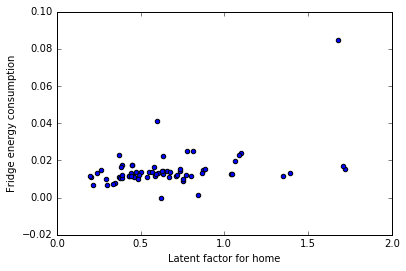

In [21]:
import matplotlib.pyplot as plt
plt.scatter(Y, pd.DataFrame(A)['fridge_7'])
plt.xlabel("Latent factor for home")
plt.ylabel("Fridge energy consumption")

In [22]:
X_m = pd.DataFrame(X)
X_m.columns = A.columns

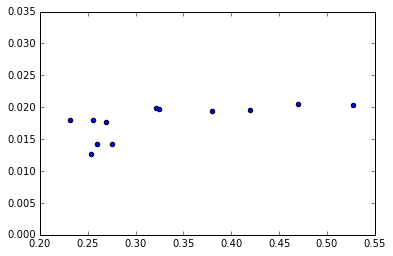

In [31]:
plt.scatter(X_m.values.flatten()[12:],X_m.values.flatten()[:12])

In [206]:
dds = [438, 579, 724, 747, 617, 376]

In [215]:
X_m.values.flatten()[:6]

array([ 0.06953881,  0.13357938,  0.20515153,  0.22322771,  0.15941742,
        0.08067859])

In [23]:
plt.scatter(X_m.values.flatten()[:], dds)
plt.xlabel("Latent factor for month")
plt.ylabel("Degree days per month")

NameError: name 'dds' is not defined

In [183]:
pd.DataFrame(Y).corrwith(pd.DataFrame(A)['hvac_10'])

0    0.019238
dtype: float64

In [168]:
error_lat

{1: 26.801509765613513,
 2: 32.16594754531535,
 3: 32.75057009957243,
 4: 33.608574403734316,
 5: 35.51499390605262,
 6: 34.5542641062825,
 7: 29.260989092833853,
 8: 36.03229595821327,
 9: 23.69216706014821}

In [53]:
pd.DataFrame(out[1]).T.head()

,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10
26,245.072444,468.099853,719.521842,780.840442,558.748129,282.693567
59,213.142529,407.232402,623.663812,675.819377,485.543535,247.101512
94,75.897705,143.707019,219.694360,238.534062,171.053473,87.703643
101,119.326641,227.375958,348.506622,378.596035,271.048929,138.213791
222,534.515723,1026.999975,1595.523641,1735.603353,1235.946874,618.391287


In [54]:
A.head()[appliance_cols]

,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10
26,0.052413,0.118235,0.165761,0.196560,0.132704,0.085778
59,0.016425,0.042707,0.099490,0.152449,0.052838,0.017179
94,0.003807,0.014025,0.027019,0.033336,0.019781,0.006768
101,0.041399,0.070641,0.100529,0.105438,0.076021,0.041531
222,0.104076,0.195260,0.234882,0.248390,0.193202,0.127090


In [15]:
pd.Series(error_lat)

1    32.570682
dtype: float64

In [380]:
pd.DataFrame(Y).describe()

,0
count,95.000000
mean,0.660303
std,0.342348
min,0.117898
25%,0.423632
50%,0.614642
75%,0.827686
max,1.971936


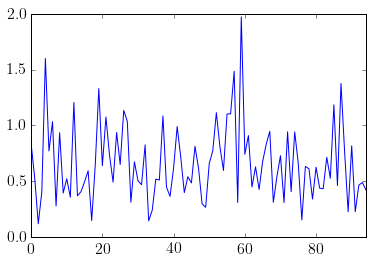

In [381]:
pd.DataFrame(Y).plot(legend=False)

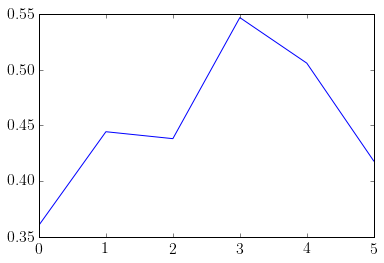

In [382]:
pd.DataFrame(X)[[0,1,2,3,4,5]].T.plot(legend=False)

In [363]:
pd.DataFrame(Y*X)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.301025,0.370936,0.365748,0.456318,0.422244,0.349034,0.321586,0.447455,0.481452,0.346902,0.369798,0.324113
1,0.191067,0.235441,0.232148,0.289636,0.268008,0.221539,0.204118,0.284010,0.305589,0.220187,0.234719,0.205722
2,0.042508,0.052380,0.051648,0.064437,0.059626,0.049288,0.045412,0.063186,0.067987,0.048987,0.052220,0.045769
3,0.145898,0.179781,0.177267,0.221164,0.204649,0.169166,0.155863,0.216868,0.233345,0.168133,0.179230,0.157088
4,0.576494,0.710382,0.700446,0.873898,0.808642,0.668436,0.615872,0.856924,0.922033,0.664354,0.708202,0.620711
5,0.277854,0.342384,0.337596,0.421195,0.389743,0.322168,0.296833,0.413013,0.444394,0.320200,0.341333,0.299166
6,0.372349,0.458825,0.452408,0.564438,0.522290,0.431733,0.397783,0.553474,0.595527,0.429097,0.457417,0.400908
7,0.099863,0.123055,0.121334,0.151380,0.140076,0.115789,0.106684,0.148440,0.159718,0.115082,0.122678,0.107522
8,0.336755,0.414965,0.409161,0.510482,0.472362,0.390463,0.359758,0.500566,0.538599,0.388078,0.413691,0.362584
9,0.141821,0.174758,0.172314,0.214984,0.198931,0.164439,0.151508,0.210808,0.226825,0.163435,0.174222,0.152699


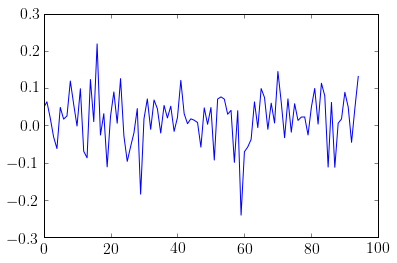

In [348]:
plt.plot(pd.DataFrame(Y*X)[0]-pd.DataFrame(X_normalised['hvac_5'].values)[0].values)

In [349]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(Y*X, X_normalised.values))
#pd.DataFrame(Y*X)-pd.DataFrame(X_normalised.values).

0.061689182092503847

In [289]:
pd.DataFrame(results).min()

dw        68.495285
fridge    41.210222
hvac      23.297621
mw        60.897398
oven      63.322534
wm        47.359437
dtype: float64

In [38]:
m = len(A)
n = len(A.columns)
k=3
Y_init = A.max().max()*np.random.rand(m, k)
pd.DataFrame(Y_init).describe()

,0,1,2
count,95.000000,95.000000,95.000000
mean,2298.792724,2590.036973,2493.324328
std,1366.027314,1337.211355,1312.536172
min,74.457818,1.682887,90.212011
25%,1070.234162,1441.592814,1509.352575
50%,2262.878502,2754.591065,2543.472756
75%,3528.501643,3792.788742,3639.383733
max,4573.696706,4574.483307,4572.175328


In [39]:
A.describe()

,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10,aggregate_5,aggregate_6,aggregate_7,aggregate_8,aggregate_9,aggregate_10
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,204.697577,410.772775,634.932650,703.427444,496.814433,243.957545,894.636166,1117.168094,1435.362421,1570.281882,1260.032510,935.727852
std,152.308577,249.724508,348.390233,343.614402,252.160506,152.017218,526.052474,563.679895,699.529397,762.214791,607.968624,515.139351
min,3.054133,2.404883,9.934549,21.709467,40.952965,8.885633,182.287521,41.541668,174.545334,485.617706,386.186584,178.216537
25%,84.733067,239.801712,409.715370,469.171234,319.873489,144.406563,538.820801,741.668213,927.531219,1050.480408,845.363953,612.034912
50%,177.884102,338.474533,572.622009,643.759674,460.979889,214.063858,781.487122,979.500122,1289.663940,1425.989990,1142.088135,801.091187
75%,289.427666,542.997314,804.441116,892.596329,617.534866,346.822327,1093.304993,1403.773315,1764.296936,1903.711792,1561.776794,1104.915527
max,894.190308,1385.010742,2130.617920,1834.047852,1386.018921,876.380493,3120.817871,3010.485352,3481.583496,4581.233398,3462.281494,3176.753418


In [54]:
prob.status

'optimal'

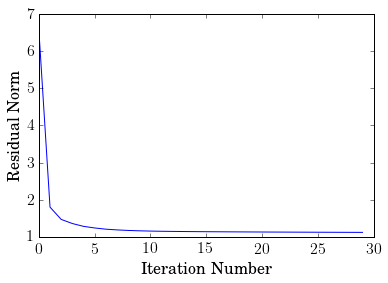

Original matrix:
        hvac_5    hvac_6    hvac_7    hvac_8    hvac_9   hvac_10  aggregate_5  \
26         NaN       NaN       NaN       NaN       NaN       NaN     0.264163   
59    0.083667  0.141433  0.211260  0.374507  0.151210  0.083204     0.314919   
94    0.018833  0.046446  0.054788  0.073571  0.038679  0.028250     0.043213   
101   0.211989  0.233945  0.213504  0.255734  0.230129  0.211738     0.114979   
222   0.534035  0.646650  0.503590  0.616900  0.629034  0.663339     0.790309   
364   0.262441  0.385219  0.342594  0.457073  0.447491  0.426416     0.245914   
545   0.389795  0.561114  0.497692  0.606508  0.555478  0.422386     0.306238   
624   0.078196  0.136574  0.140541  0.202991  0.147672  0.015232     0.098029   
661   0.245238  0.467515  0.439553  0.578096  0.531963  0.450393     0.266728   
871   0.090979  0.165842  0.185541  0.272096  0.207023  0.152141     0.132008   
946   0.240927  0.321466  0.280712  0.364962  0.305803  0.276486     0.123545   
1169  0.020

In [55]:
import matplotlib.pyplot as plt

# Show plot inline in ipython.
%matplotlib inline

# Set plot properties.
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

# Create the plot.
plt.plot(residual)
plt.xlabel('Iteration Number')
plt.ylabel('Residual Norm')
plt.show()

#
# Print results.
#
print 'Original matrix:'
print A
print 'Left factor Y:'
print Y
print 'Right factor X:'
print X
print 'Residual A - Y * X:'
print A - Y * X
print 'Residual after {} iterations: {}'.format(iter_num, prob.value)

In [58]:
pred_df = pd.DataFrame(Y*X)
pred_df.columns = X_normalised.columns
pred_df.index = X_normalised.index

In [60]:
pred_df.ix[26]

hvac_5          0.252252
hvac_6          0.386934
hvac_7          0.359241
hvac_8          0.504510
hvac_9          0.455555
hvac_10         0.360484
aggregate_5     0.273486
aggregate_6     0.462036
aggregate_7     0.448455
aggregate_8     0.335150
aggregate_9     0.348154
aggregate_10    0.310952
Name: 26, dtype: float64

In [61]:
X_normalised.ix[26]

hvac_5          0.268580
hvac_6          0.391562
hvac_7          0.354348
hvac_8          0.485952
hvac_9          0.423089
hvac_10         0.445286
aggregate_5     0.264163
aggregate_6     0.451381
aggregate_7     0.462876
aggregate_8     0.342351
aggregate_9     0.318240
aggregate_10    0.339887
Name: 26, dtype: float64

In [72]:
X_matrix.ix[26]

hvac_5           242.395737
hvac_6           543.781433
hvac_7           761.394043
hvac_8           902.418823
hvac_9           610.035828
hvac_10          395.169098
aggregate_5      958.539734
aggregate_6     1381.666504
aggregate_7     1705.293091
aggregate_8     1887.754883
aggregate_9     1365.123535
aggregate_10    1197.380859
Name: 26, dtype: float64